In [56]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import sys
import math, random, numpy as np
import json
import datetime
from pathlib import Path
from matplotlib import pyplot as plt

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torch.nn import functional as F
from torchvision import models, transforms as T

from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.decomposition import IncrementalPCA
from sklearn.neighbors import NearestNeighbors
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.metrics import (
normalized_mutual_info_score,
adjusted_rand_score,
homogeneity_score,
completeness_score,
davies_bouldin_score,
silhouette_score,
calinski_harabasz_score
)

from tqdm import tqdm

import h5py

from pyclustertend import hopkins

import time

from fvcore.nn import FlopCountAnalysis

/home/jovyan/shared/Mikhail/code/linear_assignment_.py:18: FutureWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


In [55]:
LABELED_DATASET_PATH = '/data/TCD/labeled_data_ghent.h5'
LOGATEC_DATASET_PATH = '/data/LOG-a-TEC/test_data.h5'
LABELED_ITS_DATASET_PATH = '/data/ITS/labeled_data_ITS_band.h5'

In [10]:
# Setup GPU
if torch.cuda.is_available():
    torch.cuda.set_device(0)
    device = torch.device('cuda')
    torch.backends.cudnn.benchmark = False
    pin_memory = True
else:
    device = torch.device('cpu')
    pin_memory = False

#print("Current device: ", torch.cuda.current_device())  
print("Current device: ", torch.cuda.is_available())

Current device:  True


In [57]:
from deep_clastering.datasets import LogatecDataset, LabeledGhentDataset, LabeledITSDataset 
from deep_clastering.cnn import Simple_CNN_1D
from deep_clastering.visualization import get_averaged_clusters, plot_averaged_clusters_spectograms
from deep_clastering.visualization import plot_tsne, plot_labels_dist_across_clusters

In [39]:
def train_epoch(
    model, 
    optimizer,
    train_dataset,
    train_config
    ):
    """This function will train for single epoch. We use AMP (automatic mixed 
    precision) for faster computation."""
    
    num_workers = train_config['num_workers']
    batch_size = train_config['batch_size']
    
    # Construct dataset loader for Torch
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=True,
        pin_memory=pin_memory,
        drop_last=False,
        prefetch_factor=32
    )

    # Storage for tracking running loss
    running_loss = []
    # Progress bar for easier tracking of the status
    pbar = tqdm(train_loader, desc='training', unit='batch')
    model.train()
    for (images, labels) in pbar:
        # Load images and pseudo-labels
        images = images.to(device, torch.float32)
        labels = labels.to(device, torch.long)
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # with torch.cuda.amp.autocast():
        # Forward pass to get output/logits
        outputs = model(images)
        # Calculate loss
        loss = F.cross_entropy(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()
        # scaler.scale(loss).backward()

        # Update parameters
        optimizer.step()

        # Summary info (current loss)
        running_loss.append(loss.item())

        # Calculate running loss
        total_loss = sum(running_loss) / len(running_loss)

        # Obtain learning rate
        learning_rate = get_lr(optimizer)

        # Print progress and current state of the NN training
        pbar.set_postfix(loss=total_loss, lr=learning_rate)

        # Update scheduler
        #scheduler.step(total_loss)
    
    # Return stats
    return {'loss': total_loss, 'running_loss': running_loss}

def extract_features(model, dataset, train_config):
    
    num_workers = train_config['num_workers']
    batch_size = train_config['batch_size']
    
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=False,
        pin_memory=pin_memory,
        drop_last=False,
        prefetch_factor=32
    )
    
    features = []
    
    model_features = model.feature_layers
    model_features.eval()
    
    for imgs, labels in dataloader:
        imgs = imgs.to(device, torch.float32)
        cur_features = model_features(imgs).detach().cpu()
        features.append(cur_features.view((len(imgs), -1)))
        
    return torch.cat(features)
    
def make_clusters(
    model:nn.Module, 
    dataset:Dataset,
    train_config:set,
    k_means_init:np.ndarray|str="k-means++",
    batch_size:int=1024)->np.array:
    """
    k_means_init: starting point for clustering algorithm or "k-means++"
    Generate new pseudo labels for the dataset. See arXiv:1807.05520
    """
    kmeans_clusters = train_config['kmeans_clusters']
    pca_dim = train_config['kmeans_clusters']
    
    kmeans = MiniBatchKMeans(
        n_clusters=kmeans_clusters, 
        batch_size=batch_size, 
        init_size=3*kmeans_clusters, 
        n_init=3
    )
    
    pca = IncrementalPCA(
        n_components=pca_dim, 
        batch_size=batch_size, 
        whiten=True)
    
    # Extract features with NN
    features = extract_features(model, dataset, train_config)

    # Remove axes of length one since the output of the AvgPoolLayer is 4 dimensional.
    features = np.squeeze(features)

    # Remove possible NaN and inf values.
    features[np.isfinite(features)==False] = 0
    
    start_time = time.time()
    # Reduce feature space with PCA
    reduced = pca.fit_transform(features)

    # L2 normalization
    norm = np.linalg.norm(reduced, axis=1)
    reduced = reduced / norm[:, np.newaxis]
    
    end_time = time.time()
    print("--- %s seconds for PCA and L2 norm---" % (time.time() - start_time))

    # Perform clustering/pseudo-labeling with KMeans
    pseudo_labels = kmeans.fit_predict(reduced)
    
    return pseudo_labels, features, reduced, kmeans.cluster_centers_

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    

In [99]:
def train(
    model,
    train_dataset,
    train_config
):
    # Train loop
    all_stats = []
    
    d_t_string = datetime.datetime.now().strftime("%H_%M_%S_%d_%m_%Y")
    
    print("\n=====Training parameters=====")
    print("Num clusters: ", train_config['kmeans_clusters'])
    print("Num classes: ", train_config['num_classes'])
    print("dataset path: ", DATASET_PATH)
    print("Max epochs: ", train_config['num_epochs'])
    print("PCA dimensions: ", train_config['pca_dim'])
    
    if hasattr(train_dataset, 'name'):
        dataset_name = train_dataset.name
    else:
        dataset_name = 'unknown_data'

    if hasattr(model, 'name'):
        model_name = model.name
    else: 
        model_name = 'unknown_model'
    
    SAVE_MODEL_PATH = (
        f"/results/models/{dataset_name}_{train_config['kmeans_clusters']}"
        f"pca_{train_config['pca_dim']}"
        f"_e_{train_config['num_epochs']}_{model_name}_{d_t_string}_.pt")
    

    SAVE_STAT_PATH = (
        f"/results/stats/{dataset_name}_{train_config['kmeans_clusters']}"
        f"pca_{train_config['pca_dim']}"
        f"_e_{train_config['num_epochs']}_{model_name}_{d_t_string}_stats.json")
    
    for epoch in range(train_config['num_epochs']):

        print("\n Epoch:")
        print(epoch)
        
        # generate labels
        if epoch % NUM_LEARNING_ITER == 0:
            
            if epoch > 0:
                prev_pseudo_labels = pseudo_labels
            
            if epoch == 0:
                cluster_centers = "k-means++"
            
            else:
                cluster_centers = prev_cluster_centers
        
        # make new clusters based on previous labling
        pseudo_labels, features, reduced, prev_cluster_centers \
        = make_clusters(model, train_dataset, train_config, cluster_centers)  

        # indicator for convergence
        if epoch > 0:
            nmi = normalized_mutual_info_score(prev_pseudo_labels, pseudo_labels)
            print(f"NMI t/t-1: {nmi}")
    
        # make new dataset with labels matched to images (Spectrum data)
        train_dataset.labels = pseudo_labels

        # Optimizer
        optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
    
        # Train for one epoch
        stats = train_epoch(model, optimizer, train_dataset, train_config)
        all_stats.append(stats)
    
        # Save the current model state.
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': stats['running_loss'],
            }, SAVE_MODEL_PATH)

        # Save the stat data in .json file.
        with open(SAVE_STAT_PATH, 'w') as f:
            json.dump(all_stats, f, indent=2)
    

In [76]:
def calc_label_based_metrics(labels_a, labels_b):
    nmi = normalized_mutual_info_score(labels_a, labels_b)
    ari = adjusted_rand_score(labels_a, labels_b)
    hsc = homogeneity_score(labels_a, labels_b)
    cpl = completeness_score(labels_a, labels_b)
    
    return nmi, ari, hsc, cpl
    
    
def calc_distance_based_metrics(features, labels):
    db_score = 0
    h_score = 0
    s_score = 0
    ch_score = 0

    # Calculate Davis-Bouldin score
    db_score = davies_bouldin_score(features, labels)

    # Calculate Hopkins score
    h_score = hopkins(features, sampling_size=1000)

    # Calculate Silhouette score
    selected_ids = np.random.choice(len(features), size=1000)
    s_score = silhouette_score(features[selected_ids], labels[selected_ids], metric='euclidean')
    
    # Calculate Calinski-Harabasz score
    ch_score = calinski_harabasz_score(features, labels)
    
    return db_score, h_score, s_score, ch_score
    
def calculate_complexity(model, train_dataset):
    
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Number of parameters: {total_params}")
    
    # Create DataLoader for training
    data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)
    single_batch = next(iter(data_loader))
    s = single_batch[0].to(device)

    flops = FlopCountAnalysis(model, s)
    print(f"GFLOPS: {flops.total()/1_000_000_000}")
    
    
def iterate_eval_kmeans_inits(pseudo_labels, labels_array, iter_num=100):
    nmi_list = np.zeros(iter_num)
    ari_list = np.zeros(iter_num)
    chs_list = np.zeros(iter_num)
    ccs_list = np.zeros(iter_num)
    for i in range(iter_num):
        kmeans = MiniBatchKMeans(n_clusters=KMEANS_CLUSTERS, batch_size=256, 
                                 init_size=3*KMEANS_CLUSTERS, random_state=i, n_init=3)
        pseudo_labels = list(kmeans.fit_predict(reduced))

        nmi, ari, chs, ccs = calc_label_based_metrics(labels_array, pseudo_labels)
        nmi_list.append(nmi)
        ari_list.append(ari)
        chs_list.append(chs)
        ccs_list.append(ccs)


    print('Best nmi for random_state=', np.argmax(nmi_list), ', nmi=', nmi_list.max())
    print('Best ari for random_state=', np.argmax(ari_list), ', ari=', ari_list.max())
    print('Best chs for random_state=', np.argmax(chs_list), ', hsc=', chs_list.max())
    print('Best ccs for random_state=', np.argmax(ccs_list), ', cpl=', ccs_list.max())

In [100]:
# Train loop

train_config = {
'batch_size': 1024,
'num_workers': 12,
'kmeans_clusters': 10,
'num_classes': 10,
'pca_dim': 20,
'num_epochs': 10 # should be ~250
}

model = Simple_CNN_1D(features_size = 100, n_classes=10)
model.to(device)

train_dataset = LogatecDataset(LOGATEC_DATASET_PATH, transform=torch.tensor, scale=True)

train(model, train_dataset, train_config)
        


=====Training parameters=====
Num clusters:  10
Num classes:  10
dataset path:  ../data/LOG-a-TEC/test_data.h5
Max epochs:  10
PCA dimensions:  20

 Epoch:
0
--- 2.0532031059265137 seconds for PCA and L2 norm---


training: 100%|██████████| 417/417 [00:17<00:00, 23.56batch/s, loss=1.11, lr=0.0001]



 Epoch:
1
--- 2.169830083847046 seconds for PCA and L2 norm---
NMI t/t-1: 0.4515039812390654


training: 100%|██████████| 417/417 [00:17<00:00, 23.37batch/s, loss=0.726, lr=0.0001]



 Epoch:
2
--- 2.113976240158081 seconds for PCA and L2 norm---
NMI t/t-1: 0.5977781857544489


training: 100%|██████████| 417/417 [00:18<00:00, 22.34batch/s, loss=0.873, lr=0.0001]



 Epoch:
3
--- 2.090531826019287 seconds for PCA and L2 norm---
NMI t/t-1: 0.6924762945392952


training: 100%|██████████| 417/417 [00:19<00:00, 21.68batch/s, loss=0.722, lr=0.0001]



 Epoch:
4
--- 2.062922954559326 seconds for PCA and L2 norm---
NMI t/t-1: 0.6395443611260696


training: 100%|██████████| 417/417 [00:17<00:00, 24.09batch/s, loss=0.92, lr=0.0001] 



 Epoch:
5
--- 2.0180513858795166 seconds for PCA and L2 norm---
NMI t/t-1: 0.571361973797254


training: 100%|██████████| 417/417 [00:17<00:00, 23.58batch/s, loss=0.678, lr=0.0001]



 Epoch:
6
--- 2.0815722942352295 seconds for PCA and L2 norm---
NMI t/t-1: 0.6169192778880341


training: 100%|██████████| 417/417 [00:17<00:00, 23.23batch/s, loss=0.996, lr=0.0001]



 Epoch:
7
--- 2.0503430366516113 seconds for PCA and L2 norm---
NMI t/t-1: 0.6061462564329817


training: 100%|██████████| 417/417 [00:17<00:00, 23.40batch/s, loss=0.719, lr=0.0001]



 Epoch:
8
--- 2.203738212585449 seconds for PCA and L2 norm---
NMI t/t-1: 0.5485104195025939


training: 100%|██████████| 417/417 [00:18<00:00, 23.11batch/s, loss=0.797, lr=0.0001]



 Epoch:
9
--- 2.1851577758789062 seconds for PCA and L2 norm---
NMI t/t-1: 0.5883973170946005


training: 100%|██████████| 417/417 [00:17<00:00, 23.51batch/s, loss=0.792, lr=0.0001]


In [101]:
train_dataset = LogatecDataset(DATASET_PATH, transform=torch.tensor, scale=True)

model_filename = '''/results/models/LogatecDataset_10pca_20_e_10_Simple_CNN_1D_13_39_53_09_09_2024_.pt'''
model = Simple_CNN_1D(n_classes=10)

# Optimizer for NN
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)

# Load model
checkpoint = torch.load(model_filename, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

# Loading of the optimizer should be done after the model transfer to device
# in order to avoid loading optimizer on cpu. Solution found on:
# https://github.com/pytorch/pytorch/issues/8741
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
loaded_epoch = checkpoint['epoch'] + 1 # Add 1 because of 0-indexing
loss = checkpoint['loss']

model.to(device)

scaler = torch.cuda.amp.GradScaler()

In [102]:
pca = IncrementalPCA(n_components=train_config['pca_dim'], batch_size=256, whiten=True)

kmeans = MiniBatchKMeans(n_clusters=KMEANS_CLUSTERS, batch_size=256, 
                         init_size=3*KMEANS_CLUSTERS, random_state=97, n_init=3)

pseudo_labels, features, reduced, _ = make_clusters(model, train_dataset, train_config)

--- 2.1777071952819824 seconds for PCA and L2 norm---


In [103]:
spectograms = []
labels = []

selected_indices = np.random.choice(len(train_dataset), size = 10000)

for i in selected_indices:
    spectograms.append(train_dataset[i][0][0].numpy())
    labels.append(train_dataset[i][1])
    
spectograms = np.array(spectograms)
    
averaged_clusters, cluster_real_classes \
=get_averaged_clusters(pseudo_labels[selected_indices], spectograms)

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Average per-cluster'}, xlabel='FFT bins'>)

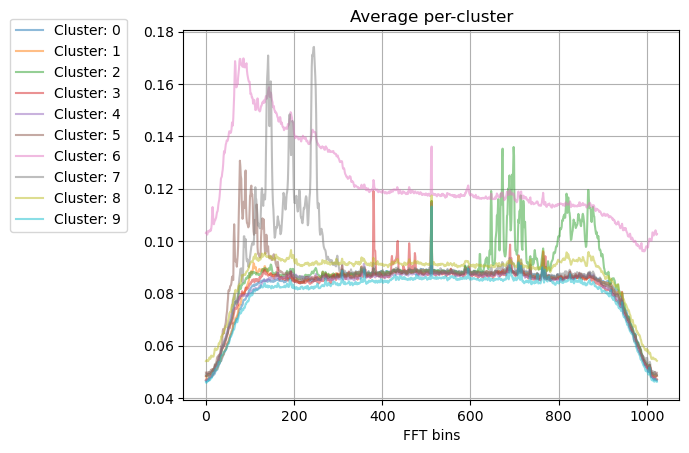

In [95]:
plot_averaged_clusters_spectograms(averaged_clusters)

(<Figure size 640x480 with 1 Axes>, <Axes: >)

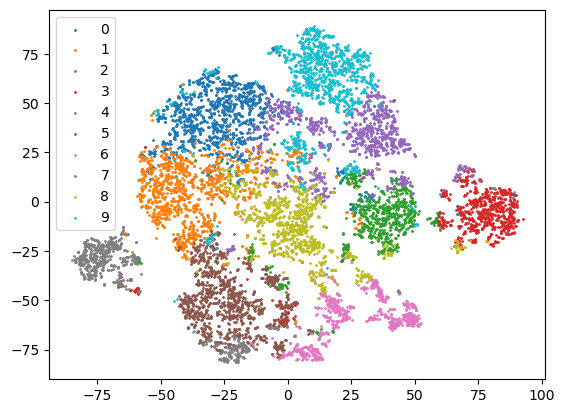

In [96]:
plot_tsne(pseudo_labels[selected_indices], reduced[selected_indices] )

In [104]:
train_config = {
'batch_size': 1024,
'num_workers': 12,
'kmeans_clusters': 10,
'num_classes': 10,
'pca_dim': 20,
'num_epochs': 10 # should be ~250
}

model = Simple_CNN_1D(features_size = 100, n_classes=10)
model.to(device)

train_dataset = LabeledGhentDataset(LABELED_DATASET_PATH, transform=torch.tensor, scale=True)

train(model, train_dataset, train_config)


=====Training parameters=====
Num clusters:  10
Num classes:  10
dataset path:  ../data/LOG-a-TEC/test_data.h5
Max epochs:  10
PCA dimensions:  20

 Epoch:
0
--- 0.8717541694641113 seconds for PCA and L2 norm---


training: 100%|██████████| 172/172 [00:14<00:00, 12.03batch/s, loss=0.402, lr=0.0001]



 Epoch:
1
--- 0.9183573722839355 seconds for PCA and L2 norm---
NMI t/t-1: 0.574987168263782


training: 100%|██████████| 172/172 [00:14<00:00, 11.85batch/s, loss=0.0297, lr=0.0001]


 Epoch:
2


--- 0.8525664806365967 seconds for PCA and L2 norm---
NMI t/t-1: 0.759673390133669


training: 100%|██████████| 172/172 [00:14<00:00, 11.98batch/s, loss=0.00743, lr=0.0001]


 Epoch:
3


--- 0.8612759113311768 seconds for PCA and L2 norm---
NMI t/t-1: 0.7569973466892388


training: 100%|██████████| 172/172 [00:13<00:00, 12.69batch/s, loss=0.00412, lr=0.0001]



 Epoch:
4
--- 0.8709878921508789 seconds for PCA and L2 norm---
NMI t/t-1: 0.7494867050491562


training: 100%|██████████| 172/172 [00:13<00:00, 12.34batch/s, loss=0.00237, lr=0.0001]



 Epoch:
5
--- 0.8952841758728027 seconds for PCA and L2 norm---
NMI t/t-1: 0.7795627832363803


training: 100%|██████████| 172/172 [00:14<00:00, 12.09batch/s, loss=0.00145, lr=0.0001]


 Epoch:
6


--- 0.8777706623077393 seconds for PCA and L2 norm---
NMI t/t-1: 0.7812118446886717


training: 100%|██████████| 172/172 [00:14<00:00, 11.75batch/s, loss=0.00104, lr=0.0001]


 Epoch:
7


--- 0.8895447254180908 seconds for PCA and L2 norm---
NMI t/t-1: 0.7846665595430593


training: 100%|██████████| 172/172 [00:15<00:00, 11.17batch/s, loss=0.000706, lr=0.0001]


 Epoch:
8


--- 0.8777554035186768 seconds for PCA and L2 norm---
NMI t/t-1: 0.7891623083846413


training: 100%|██████████| 172/172 [00:14<00:00, 12.06batch/s, loss=0.000375, lr=0.0001]


 Epoch:
9


--- 0.889153003692627 seconds for PCA and L2 norm---
NMI t/t-1: 0.8533277399918773


training: 100%|██████████| 172/172 [00:14<00:00, 11.73batch/s, loss=0.000321, lr=0.0001]


In [105]:
train_dataset = LabeledGhentDataset(LABELED_DATASET_PATH, transform=torch.tensor, scale=True)

model_filename = '../results/models/LabeledGhentDataset_10pca_20_e_10_Simple_CNN_1D_13_47_35_09_09_2024_.pt'
model = Simple_CNN_1D(n_classes=10)

# Optimizer for NN
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)

# Load model
checkpoint = torch.load(model_filename, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

# Loading of the optimizer should be done after the model transfer to device
# in order to avoid loading optimizer on cpu. Solution found on:
# https://github.com/pytorch/pytorch/issues/8741
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
loaded_epoch = checkpoint['epoch'] + 1 # Add 1 because of 0-indexing
loss = checkpoint['loss']

model.to(device)

scaler = torch.cuda.amp.GradScaler()

In [106]:
pca = IncrementalPCA(n_components=train_config['pca_dim'], batch_size=256, whiten=True)

kmeans = MiniBatchKMeans(n_clusters=KMEANS_CLUSTERS, batch_size=256, 
                         init_size=3*KMEANS_CLUSTERS, random_state=97, n_init=3)

pseudo_labels, features, reduced, _ = make_clusters(model, train_dataset, train_config)

--- 0.8395452499389648 seconds for PCA and L2 norm---


In [107]:
spectograms = []
labels = []

selected_indices = np.random.choice(len(train_dataset), size = 10000)

for i in selected_indices:
    spectograms.append(train_dataset[i][0][0].numpy())
    labels.append(train_dataset[i][1])
    
spectograms = np.array(spectograms)


averaged_clusters, clusters_centers \
= get_averaged_clusters(pseudo_labels[selected_indices], spectograms)

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Average per-cluster'}, xlabel='FFT bins'>)

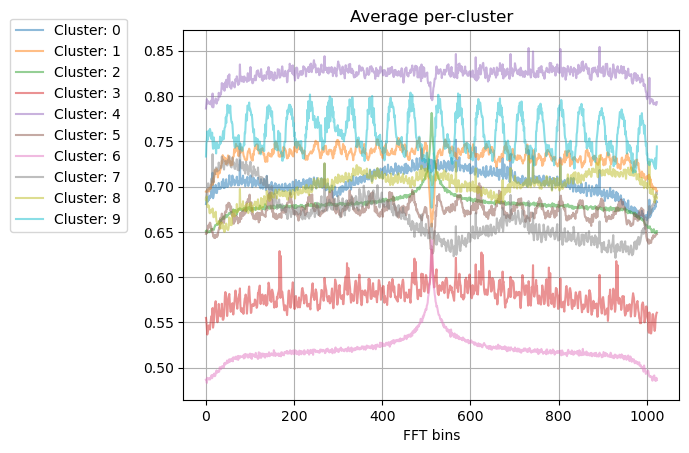

In [108]:
plot_averaged_clusters_spectograms(averaged_clusters)

(<Figure size 640x480 with 1 Axes>, <Axes: >)

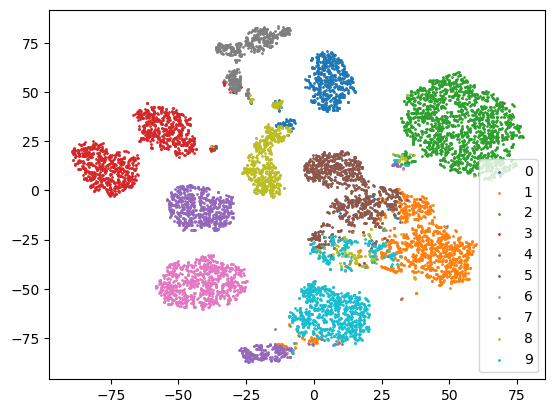

In [109]:
plot_tsne(pseudo_labels[selected_indices], reduced[selected_indices] )